In [363]:
from __future__ import division
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline

# Parameters

In [569]:
# should be large enough s.t. border effects are not impacting result too much 
max_stock = 200

n_customers = 500
sim_buy_mean_period_days = 10
n_pos = 10


# distribution of the purchased sim bulk sizes
# this should normally be much smaller than max_stock 
bulk_size_distro={
   10: .4,
   15: .4,
   20: .2
}

# distribution of the bulk purchase periods
bulk_periods_distro={

   # don't put period=0 here... 
    
   2: .50,
   4: .3,
   6: .2
}


In [570]:
def ev(dist):

    assert sum(dist.values()) == 1
    
    return sum(dist[v] * v for v in dist.keys())
    

In [571]:

e_sim = n_customers/(sim_buy_mean_period_days*n_pos)

print """
for each pos:
    - expected number of daily sim sold: {}
    - expected number of daily sim bought: {}
    
(those two should be similar to reach equilibrium)    
""".format(e_sim, ev(bulk_size_distro)/ev(bulk_periods_distro))


for each pos:
    - expected number of daily sim sold: 5.0
    - expected number of daily sim bought: 4.11764705882
    
(those two should be similar to reach equilibrium)    



# Utils

In [572]:
# transition matrix size, from stock 0 to max_stock
T_size = max_stock + 1

def post_pad(vect):
    """
    pads the end of this vectors with 0s s.t. it is as long as T_size        
    """
    return np.pad(vect, [0, T_size-len(vect)], "constant", constant_values=0)


def pre_pad(vect, n_pads):
    """
    pads the beginning of this vectors with the requested amount of 0s
    """
    return np.pad(vect, [n_pads, 0], "constant", constant_values=0)
    

def binom_pmf(n, p):
    """
    return a binomial(n,p) pmf
    """
    def _pmf(k):
        return stats.binom.pmf(k, n, p)
    return _pmf

# Customer buying sims

In [573]:
n = n_customers/sim_buy_mean_period_days
p = 1/n_pos

p_delta = binom_pmf(n, p )

"Stock decrease due to customer buying SIMs should follow a Binomial({}, {})".format(n, p)

'Stock decrease due to customer buying SIMs should follow a Binomial(50.0, 0.1)'

In [574]:
def sim_delta_pmf_up_to(max_delta):
    """
    Return a pmf of size max_delta + 1 containing the probability of 
    of all stock decrement sizes for size ranging from 0 to max_delta.
    
    This simply encapsulate the fact a stock cannot go to negative values
    """
    
    pmf = np.array([p_delta(k) for k in range(max_delta+1)])
    
    # All the binomial values corresponding to impossible stock decrease simply pile
    # up as a full out of stock situation (we're not modelling customer re-trying by going to other shops...)
    pmf[-1] += 1 - pmf.sum()
    
    # fixing small rounding errors
    for idx, val in enumerate(pmf):
        if val < 0 and val > -1e-10:
            pmf[idx] = 0
        if val > 1 and val < 1 + 1e-10:
            pmf[idx] = 1
            
    return pmf
    

This is left multiplying matrix, i.e. $T_{cust}*x(t) = x(t+1)$
many Markov chain doc seem to put T_cust on the right, though I find it messy for the LS to solve

 => "from stock" is on top and "to stock" is on the size

 stock level are modeled as their corresponding index in the matrix
 => $T_{cust}(10,15)$ corresponds to the probability to transit from stock=15 to stock=12 in one day


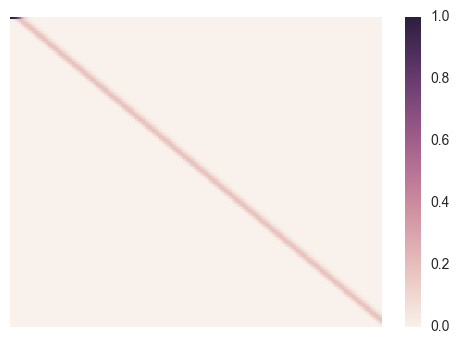

In [582]:
# stock daily transition matrix due to customer buying sims


T_cust = np.array(
    [post_pad(sim_delta_pmf_up_to(i)[::-1]) for i in range(T_size)]
).T
sns.heatmap(T_cust, xticklabels=False, yticklabels=False);

# POS bulk purchases

In [576]:
max_bulk_size = max(bulk_size_distro.keys())


In [577]:
def bulk_delta_pseudo_pmf_up_to(max_delta):
        
    pseudo_pmf = np.array([0.] * max(max_delta+1, max_bulk_size+1))    
    
    for delta in bulk_size_distro.keys():        
        for period in bulk_periods_distro.keys():                                
            pseudo_pmf[delta] += bulk_periods_distro[period] * bulk_size_distro[delta]/period
    
    pseudo_pmf[0] = 1 - pseudo_pmf.sum()
    
    # due to the truncation related to max_stock, we do not capture transitions larger than max_delta
    # => the returned vector might sum up to a positive value smaller than 1. 
    # We do not re-normalize though, so that all transition probs are correct, but simply 
    # some of them are missing in the computation.
    # Just make sure to keep a high enough max_stock s.t. the discarded probabilities remain small
    return pseudo_pmf[:max_delta+1]
        

In [578]:
def bulk_delta_pseudo_pmf_up_to(max_delta):
        
    pseudo_pmf = np.array([0.] * max(max_delta+1, max_bulk_size+1))    
    
    for delta in bulk_size_distro.keys():        
        for period in bulk_periods_distro.keys():                                
            pseudo_pmf[delta] += bulk_periods_distro[period] * bulk_size_distro[delta]/period
    
    pseudo_pmf[0] = 1 - pseudo_pmf.sum()
    
    # due to the truncation related to max_stock, we do not capture transitions larger than max_delta
    # => the returned vector might sum up to a positive value smaller than 1. 
    # We do not re-normalize though, so that all transition probs are correct, but simply 
    # some of them are missing in the computation.
    # Just make sure to keep a high enough max_stock s.t. the discarded probabilities remain small
    
    
    pseudo_pmf = pseudo_pmf[:max_delta+1]
    
    pseudo_pmf[-1] += 1 - pseudo_pmf.sum()
    
    return pseudo_pmf
        

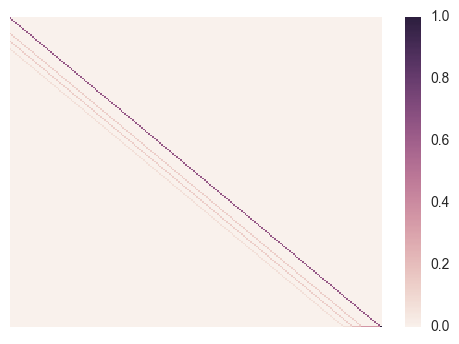

In [583]:
# stock daily transition matrix due to pos buying bulks of sims

T_bulk = np.array(
    [post_pad(pre_pad(bulk_delta_pseudo_pmf_up_to(T_size-i-1), i)) for i in range(T_size)]
).T
sns.heatmap(T_bulk, xticklabels=False, yticklabels=False);

# Transition matrix and stationary distribution, visually

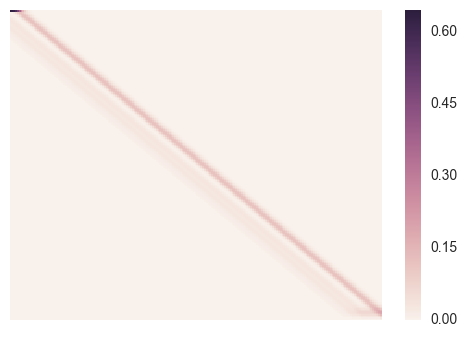

In [580]:
T = T_cust.dot(T_bulk) 
sns.heatmap(T, xticklabels=False, yticklabels=False);

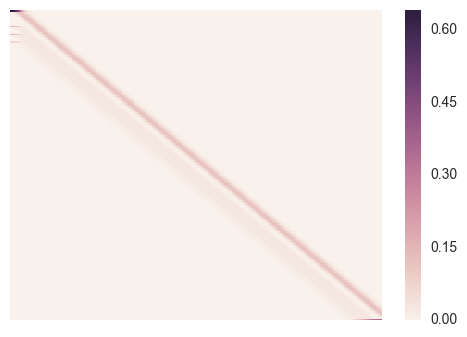

In [639]:
sns.heatmap(T_bulk.dot(T_cust) , xticklabels=False, yticklabels=False);

CPU times: user 19.7 s, sys: 269 ms, total: 19.9 s
Wall time: 19.9 s


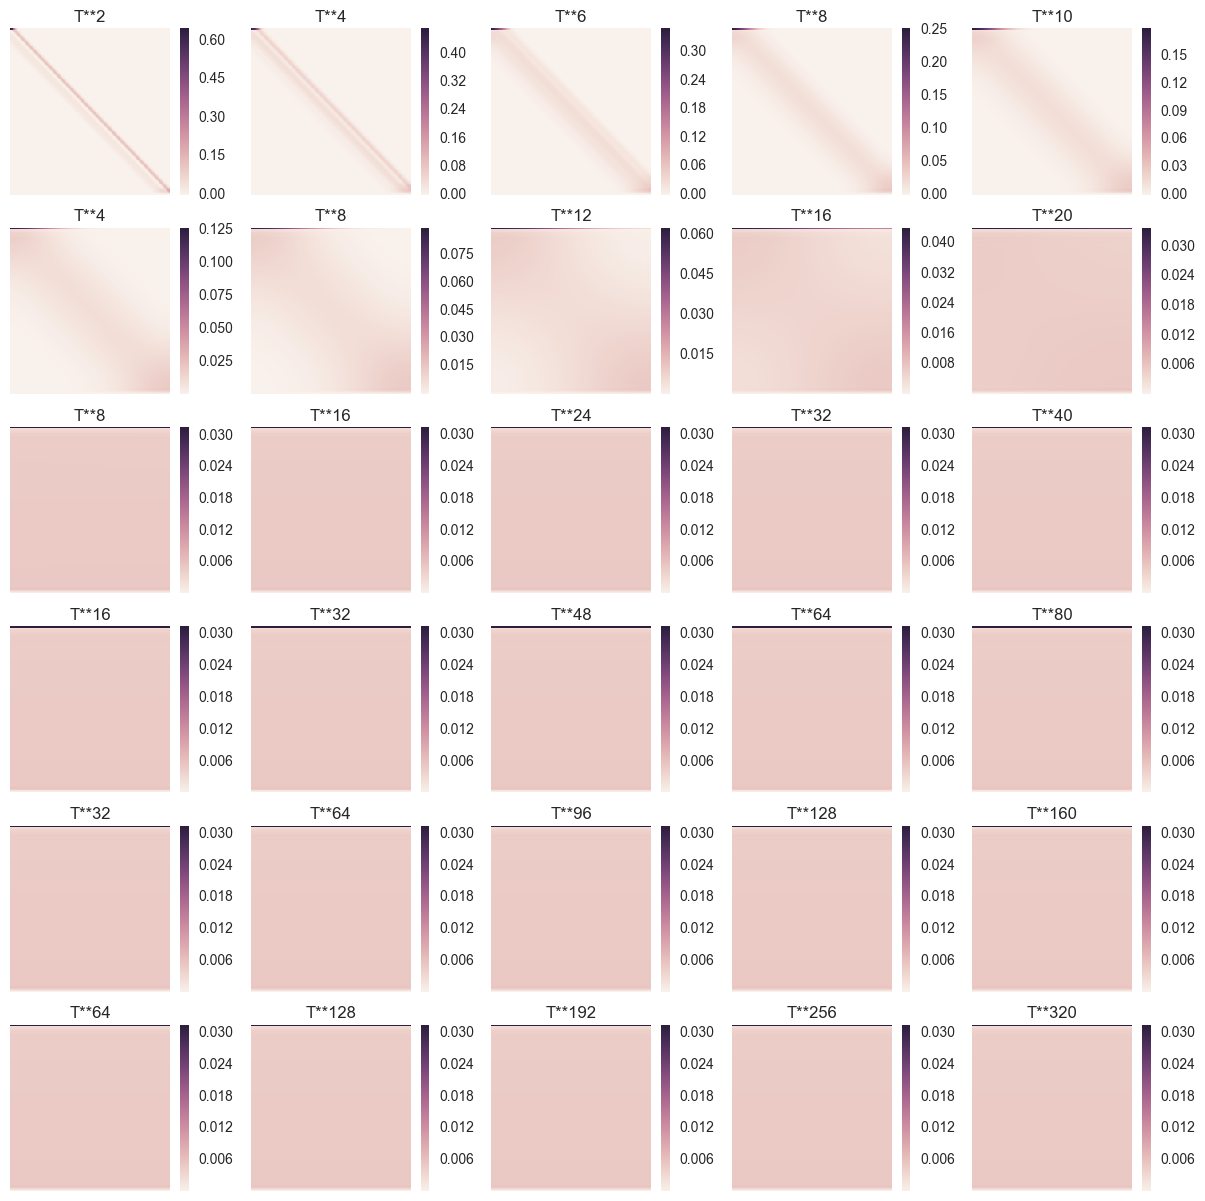

In [581]:
%%time

t = T
rows = 6
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15, rows*2.5 ))

for r in range(rows):
    for c in range(cols):
        sns.heatmap(t, ax=ax[r, c], xticklabels=False, yticklabels=False);
        ax[r, c].set_title("T**{}".format(2**(r+1)*(c+1)))
        t = t.dot(t)


# Analytically

In [622]:
# solving for Ax = x
A = T - np.identity(T.shape[0])

# adding one more constraint force x being a probability vector
prob_const = np.ones([1, T.shape[1]])
A2 = np.concatenate([A, prob_const], axis=0)

b = np.concatenate([np.zeros([t.shape[0], 1]), [[1]]], axis=0)

In [623]:
x, res, rank, s = np.linalg.lstsq(A2, b)

In [625]:
# residuals of the least square approximation
res

array([  1.87771989e-32])

In [635]:
stat_dist = x.T[0]

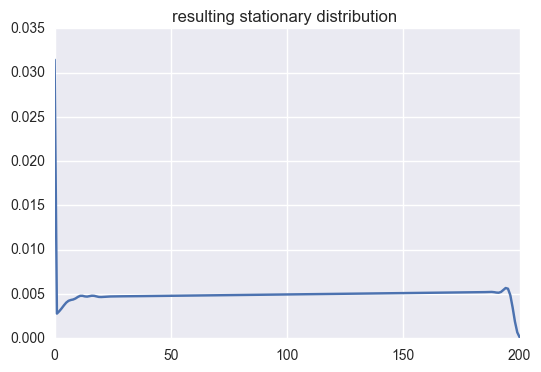

In [637]:
pd.Series(stat_dist).plot(title="resulting stationary distribution ");